# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.390988
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 
This is because we know that e^0=1 since our weights are very close to zero,
Sj~0, where Sj is the score for the jth class for say an input Xi. Now consider
an input the softmax loss function would be of the form = -log(e^0/(e^0+e^0+e^0+e^0+e^0... 10 times))
since we have 10 classes. which reduces to -log(1/10) = -log(0.1)
Now this will be across all inputs as well, so the mean or the total loss would be
1/N * (N * (-log(0.1))) = -(log(0.1))

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 100)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 100)

numerical: -2.531355 analytic: -2.531355, relative error: 6.946173e-10
numerical: 0.810639 analytic: 0.810639, relative error: 4.468139e-09
numerical: 1.924442 analytic: 1.924442, relative error: 7.558841e-10
numerical: -1.203214 analytic: -1.203214, relative error: 3.405034e-09
numerical: 3.341637 analytic: 3.341637, relative error: 6.289752e-10
numerical: -0.619332 analytic: -0.619332, relative error: 8.329706e-10
numerical: 4.110635 analytic: 4.110635, relative error: 5.582156e-10
numerical: -0.529608 analytic: -0.529608, relative error: 9.599540e-09
numerical: -2.334123 analytic: -2.334123, relative error: 3.660917e-11
numerical: -2.922881 analytic: -2.922881, relative error: 4.009261e-09
numerical: -0.258704 analytic: -0.258704, relative error: 8.082600e-09
numerical: 1.631413 analytic: 1.631413, relative error: 2.244813e-09
numerical: -0.141468 analytic: -0.141468, relative error: 1.776175e-08
numerical: -4.533192 analytic: -4.533192, relative error: 7.301352e-10
numerical: 1.604

numerical: 1.493639 analytic: 1.493639, relative error: 2.795828e-10
numerical: 0.777351 analytic: 0.777351, relative error: 3.050778e-09
numerical: 1.137454 analytic: 1.137454, relative error: 5.727769e-09
numerical: -1.193187 analytic: -1.193187, relative error: 5.419247e-09
numerical: -3.550097 analytic: -3.550097, relative error: 1.961355e-09
numerical: 0.385890 analytic: 0.385890, relative error: 1.845966e-08
numerical: -0.484374 analytic: -0.484374, relative error: 7.656733e-09
numerical: 0.204579 analytic: 0.204579, relative error: 3.016325e-09
numerical: 0.790163 analytic: 0.790163, relative error: 4.785472e-09
numerical: 0.167805 analytic: 0.167805, relative error: 5.699567e-08
numerical: 2.208280 analytic: 2.208280, relative error: 2.434796e-09
numerical: -4.508730 analytic: -4.508730, relative error: 5.431798e-10
numerical: -2.153319 analytic: -2.153319, relative error: 1.178232e-09
numerical: 2.109852 analytic: 2.109852, relative error: 6.373476e-10
numerical: -4.652922 ana

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %.28f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %.18f' % grad_difference)

naive loss: 2.390988e+00 computed in 0.083434s
vectorized loss: 2.390988e+00 computed in 0.093465s
Loss difference: 0.0000000000000004440892098501
Gradient difference: 0.000000000000369026


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
regs = [2.4e4]
lrs = [2e-7]
for rg in regs:
    for lr in lrs:
        sfm = Softmax()
        loss_hist = sfm.train(X_train, y_train, learning_rate=lr, reg=rg,
                              num_iters=1500, verbose=True)
        y_train_pred = sfm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = sfm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        if best_val<val_acc:
            best_val=val_acc
            best_softmax=sfm
        results[(lr,rg)] = (train_acc,val_acc)
        print("reg: %d, lr %f, val_acc %f"%(rg,lr,val_acc))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 744.011142
iteration 100 / 1500: loss 109.067847
iteration 200 / 1500: loss 17.581898
iteration 300 / 1500: loss 4.363667
iteration 400 / 1500: loss 2.467312
iteration 500 / 1500: loss 2.125576
iteration 600 / 1500: loss 2.102611
iteration 700 / 1500: loss 2.107233
iteration 800 / 1500: loss 2.130462
iteration 900 / 1500: loss 2.083556
iteration 1000 / 1500: loss 2.042868
iteration 1100 / 1500: loss 2.068889
iteration 1200 / 1500: loss 2.067508
iteration 1300 / 1500: loss 2.067960
iteration 1400 / 1500: loss 2.138784
reg: 24000, lr 0.000000, val_acc 0.347000
lr 2.000000e-07 reg 2.400000e+04 train accuracy: 0.334102 val accuracy: 0.347000
best validation accuracy achieved during cross-validation: 0.347000


In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.344000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: For SVM if we add a datapoint to the training set so that the loss value (si - sj) is negative for all values of i != j where j is the the correct class, then the net loss would still be the same. However in the case of Softmax classifier, the denominator sum is the sum of all score values (elements of the X.dot(W) matrix), hence it will change.

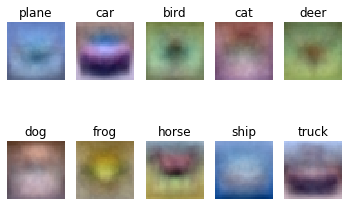

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])